In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from datetime import datetime as dt
from tqdm import tqdm
import matplotlib.font_manager as fm

def font():
    font_name = fm.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
    plt.rc('font', family = font_name)
    
def url_print(uRow = 5):
    idate = '2021'
    url_basic = 'http://openAPI.seoul.go.kr:8088/'
    uKey = '4f617954766d6f6f37354448475961'
    url_obj = '/xml/TbCorona19CountStatusJCG/1/'+str(uRow)+'/'


    url = url_basic + uKey + url_obj
    
    url_soup = url_parser(url)
    return url_soup

def url_parser(url):
    xml_url = requests.get(url)
    if xml_url.status_code == 200:
        pass
        #print('정상적으로 데이터를 받아왔습니다')
    else:
        print('데이터를 가져오지 못했습니다.')
    xml_soup = bs(xml_url.content , 'html.parser')
    #print(xml_soup)
    return xml_soup

#index 만들기
def df_columns():
    data = pd.read_csv('c:/pydata/서울특별시 코로나19 자치구별 확진자 발생동향.csv', encoding = 'cp949')
    df_index = list(data.columns)
    
    return df_index

#전체데이터 받아오기
def tot_data_save():
    df_index = df_columns()
    df1 = pd.DataFrame()
    uRow = url_print().find('list_total_count').text
    xml_soup = url_print(uRow)
    for num in tqdm(range(int(uRow)), desc = '진행률'):
        soup_data = xml_soup.select('row')[num].text
        pre_data_lst=[]
        data_lst= [] 
        text = ""
        
        #예외처리 '수집일'이 없는 경우 Nan으로 받아서 처리
        try:
            for i in soup_data:
                if i != '\n':
                    text += i
                else:
                    pre_data_lst.append(text)
                    text = ""
            for i in range(len(pre_data_lst)):
                if pre_data_lst[i] != "":
                    data_lst.append(pre_data_lst[i])
            # print(len(df_data_lst))
            df = pd.DataFrame( [data_lst], columns = df_index)
            df1 = pd.concat([df1,df], ignore_index = True)
        except:
            if len(data_lst) != 1: #마지막 데이터 20이 들어간 자리 처리
                df = pd.DataFrame( [data_lst], columns = df_index[:-1])
                df1 = pd.concat([df1,df], ignore_index = True)
    df1.to_csv('c:/pydata/seoul_covid19_info.csv', index = False, encoding = 'cp949')

#최신 자료 업데이트
def update_data():
    df = pd.read_csv('c:/pydata/seoul_covid19_info.csv', encoding = "cp949")
    url= url_print()
    #print(url)
    today_date = url.find('jcg_dt').text
    #print(today_date)
    df_index = df_columns()
    if df.loc[0][0] == today_date:

        print('최신 데이터 자료입니다')

    else:

        soup_data = url.select('row')[0].text
        pre_data_lst=[]
        data_lst= [] 
        text = ""
        df1 = pd.DataFrame()
        for i in soup_data:
            if i != '\n':
                text += i
            else:
                pre_data_lst.append(text)
                text = ""
        for i in range(len(pre_data_lst)):
            if pre_data_lst[i] != "":
                data_lst.append(pre_data_lst[i])
        # print(len(df_data_lst))
        df1 = pd.DataFrame( [data_lst], columns = df_index)
        df = pd.concat([df1,df], ignore_index = True)
        df.to_csv('c:/pydata/seoul_covid19_info.csv', index = False, encoding = 'cp949')

#프로그램 스타트
def start():
    num = int(input('데이터 자료를 가지고 있습니까? 데이터가 없다면 "1"을 기존 데이터를 가지고 있다면 "2"를 눌러주세요.'))
    data = pd.DataFrame()
    if num == 1:
        tot_data_save()
    elif num == 2: 
        data = update_data()
    else:
        print('숫자를 잘못 입력하셨습니다')
        exit()

# 기준일 날짜 처리(년월일 처리) + 일별 정리(지역구별 일별 추가 발생자)
#df['자치구 기준일'].loc[0].replace(".","")[:-2] : 문자열 처리후 날짜까지만
def daily_data(df):
    df_index = df_columns()
    new_index = []
    for i in range(len(df)):
        df['자치구 기준일'].loc[i] =  df['자치구 기준일'].loc[i].replace(".","")[:-2]
    #columns 이름 변경
    df1 = df.rename(columns = {'자치구 기준일' : '발생년월일'})
    for i in df_index:
        if i[-2:] == '추가' :
            new_index.append(i)
    new_index.insert(0,"발생년월일")

    df3 = df1[new_index] # 지역별 추가 발생자 데이터
    df3.sort_values(by = '발생년월일', ascending = True, inplace = True)
    df3.reset_index(inplace = True)
    return df3

#월별 데이터 처리(지역구별 추가 발생자)
def month_data(df):
    df_index = df_columns()
    new_index = []
    for i in range(1):
        for i in range(len(df)):
            df['자치구 기준일'].loc[i] =  df['자치구 기준일'].loc[i].replace(".","")[:-2]
    df2 = df.rename(columns = {'자치구 기준일' : '발생년월일'})
    for i in df_index:
        if i[-2:] == '추가' :
            new_index.append(i)
    new_index.insert(0,"발생년월일")
    df4 = df2[new_index]
    df4 = df4.rename(columns = {'발생년월일' : '발생년월'})
    df4 = df4.groupby('발생년월').sum()
    df4.sort_values(by = '발생년월', ascending = True, inplace = True)
    df4.reset_index(inplace = True)
    return df4

데이터 자료를 가지고 있습니까? 데이터가 없다면 "1"을 기존 데이터를 가지고 있다면 "2"를 눌러주세요.2


C:\Users\moh12\Anaconda3\envs\big_data_Intelligence_system\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-8-76075d3cab48>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by = '발생년월일', ascending = True, inplace = True)


조회할 구 입력:용산구


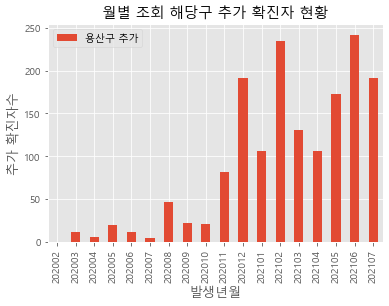

In [9]:
start()
font()
df = pd.read_csv("c:/pydata/seoul_covid19_info.csv", encoding = 'cp949')
df.drop('수집일', axis =1, inplace = True )
df1 = daily_data(df)
df2 = month_data(df)

#자치구 조회
gu = input('조회할 구 입력:')
plt.style.use('ggplot')
df2.plot(kind = 'bar', x = '발생년월', y = gu+' 추가')
plt.xlabel('발생년월', size = 13)
plt.ylabel('추가 확진자수', size = 13)
plt.title('월별 조회 해당구 추가 확진자 현황')
plt.show()

In [10]:
df1

,index,발생년월일,종로구 추가,중구 추가,용산구 추가,성동구 추가,광진구 추가,동대문구 추가,중랑구 추가,성북구 추가,...,구로구 추가,금천구 추가,영등포구 추가,동작구 추가,관악구 추가,서추구 추가,강남구 추가,송파구 추가,강동구 추가,기타 추가
0,500,20200228,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,2
1,499,20200229,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,3,3,1,0
2,498,20200301,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
3,497,20200302,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,496,20200303,0,0,0,0,0,0,0,2,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,4,20210707,11,8,26,24,27,16,5,21,...,21,7,39,15,31,32,67,32,20,30
497,3,20210708,6,10,18,36,22,13,13,20,...,18,11,22,23,19,27,57,27,32,32
498,2,20210709,3,6,17,22,24,22,12,22,...,19,12,17,23,23,29,44,26,25,22
499,1,20210710,9,10,15,20,17,18,8,17,...,20,11,23,25,32,27,58,16,14,26


In [11]:
df2

,발생년월,종로구 추가,중구 추가,용산구 추가,성동구 추가,광진구 추가,동대문구 추가,중랑구 추가,성북구 추가,강북구 추가,...,구로구 추가,금천구 추가,영등포구 추가,동작구 추가,관악구 추가,서추구 추가,강남구 추가,송파구 추가,강동구 추가,기타 추가
0,202002,0,0,0,1,1,1,0,0,0,...,0,0,0,0,1,1,4,3,1,2
1,202003,2,4,12,3,4,25,12,13,5,...,32,11,18,22,25,20,32,13,6,21
2,202004,3,2,6,13,3,5,3,9,0,...,2,0,5,8,15,14,26,12,3,15
3,202005,3,3,20,21,6,3,3,5,9,...,6,3,11,9,16,4,10,11,11,12
4,202006,3,3,12,9,3,4,14,4,10,...,45,16,27,13,54,14,9,7,11,25
5,202007,6,8,4,8,5,6,11,9,4,...,5,8,9,17,31,7,15,44,14,12
6,202008,35,30,46,31,74,73,97,238,78,...,60,33,67,105,100,75,76,158,92,169
7,202009,25,8,22,28,33,32,46,54,38,...,30,19,52,59,139,57,95,80,43,131
8,202010,7,7,21,21,11,27,22,17,15,...,22,7,18,28,90,34,74,54,20,82
9,202011,31,42,81,81,39,126,82,107,37,...,69,25,82,124,69,233,158,212,69,195
